In [1]:
from datasets import load_dataset
from tools.data_collect import Data_Processor,setup_output_file
from tools.data_judge import ReasoningOptimizer
import json
import os
import numpy as np
from pathlib import Path

 collect data  

In [2]:
cwd = Path.cwd()
config_path = cwd / "configs" / "collect_config.json"
with open(config_path, 'r', encoding='utf-8') as f:
    collect_config = json.load(f)
ds = load_dataset(collect_config['dataset_name'], split="test")
ds_demo = ds.select(range(0,400))
processor = Data_Processor(
    # api_key=os.getenv("DEEPSEEK_API_KEY"),
    api_config= collect_config,
    max_workers=10,  
)


data_name = collect_config['dataset_name'].split("/")[-1]
output_path = cwd / "exp" / "calibration" /  f"{data_name}.jsonl"
output_path.parent.mkdir(parents=True, exist_ok=True)
processor.output_file = output_path # you can set the output_file by yourself, otherwise it is set by defalt
# dataset_path = setup_output_file(collect_config)
# processor.process_dataset(ds_demo, batch_size=1000)




Using the latest cached version of the dataset since HuggingFaceH4/MATH-500 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\25670\.cache\huggingface\datasets\HuggingFaceH4___math-500\default\0.0.0\ff5b20257d8185524591543f8ff5993951537bb8 (last modified on Thu Mar 27 21:28:01 2025).


find minest reasoning length 

In [ ]:
import time
import gc
dataset_path = output_path
judge_config_path = cwd / "configs" / "judge_config.json"

with open(judge_config_path, 'r', encoding='utf-8') as f:
    judge_config = json.load(f)
judged_output = cwd / "exp" / "calibration"  / f"{data_name}-label.jsonl"
k = 20
while k<400:
    optimizer = ReasoningOptimizer(judge_config,output_path=judged_output)
    optimizer.load_data(dataset_path,range=[k,k+30])
    optimizer.run_optimization()
    optimizer
    gc.collect()
    k += 30
    time.sleep(60*10)

# shittttt! rate limit
# try to collect data devidely, but cannot collect now

give the difficult level prediction and reasoning_length prediction

In [6]:
from tools.pred import annotate_difficulty_level,predict_reasoning_length
annotate_difficulty_level(input_path=judged_output,
                          api_key="sk-28d3e9b60f9f43a0a958ae132b7fcc2f",
                        base_url="https://api.deepseek.com",
                        model_name="deepseek-chat")



Reading from: d:\math\A-reasoning_demo\exp\calibration\MATH-500-label.jsonl
Writing to:   d:\math\A-reasoning_demo\exp\calibration\MATH-500-label-level.jsonl


Annotating difficulty level: 357it [28:50,  4.85s/it]

✅ Annotation complete.


In [12]:
#  use DEEPSEEK-chat to judge the difficult level of the problem, and then give quantile in different level
from importlib import reload
import tools.Prompt
import tools.pred
reload(tools.Prompt)
reload(tools.pred)
from tools.pred import predict_reasoning_length

predict_reasoning_length(input_path=judged_output,
                          api_key="sk-28d3e9b60f9f43a0a958ae132b7fcc2f",
                        base_url="https://api.deepseek.com",
                        model_name="deepseek-chat")

Reading from: d:\math\A-reasoning_demo\exp\calibration\MATH-500-label.jsonl
Writing to:   d:\math\A-reasoning_demo\exp\calibration\MATH-500-label-level.jsonl


Predictiong reasoing length: 357it [1:21:02, 13.62s/it]

✅ prediction complete.


find the quantile and give plot

In [9]:
from sklearn.model_selection import train_test_split
data = []
judged_output = "exp\calibration\MATH-500-label.jsonl"
i = 0
with open (judged_output,'r',encoding='utf-8') as file:
    for line in file:
        a_data = json.loads(line)
        data.append({"problem":a_data.get("problem",""),"original_reasoning_length":a_data.get("original_reasoning_length",""),"r_l":a_data.get("min_valid_length",""),"level":a_data.get("pred_level",""),"pred_length":a_data.get("pred_length","ArithmeticError")})


calib, test = train_test_split(data, test_size=0.2, random_state=42)

r_ls = {1:[],2:[],3:[],4:[],5:[]
}
total_ls = []
original_ls =  {1:[],2:[],3:[],4:[],5:[]}
original_total = []
pred_ls = []
for a_data in calib:
    r_ls[a_data["level"]].append(a_data["r_l"])
    total_ls.append(a_data["r_l"])
    pred_ls.append(a_data["pred_length"])
    original_total.append(a_data['original_reasoning_length'])
    original_ls[a_data["level"]].append(a_data['original_reasoning_length'])

In [5]:
import numpy as np
print(len(test))
alpha = 0.1
l_thresh = [np.quantile(r_ls[i],1-alpha) for i in [1,2,3,4,5]]
total_thersh = np.quantile(total_ls,1-alpha)
print(l_thresh)
print(total_thersh)

72
[154.5, 224.89999999999998, 862.6, 2247.1000000000004, 6030.000000000002]
1504.2


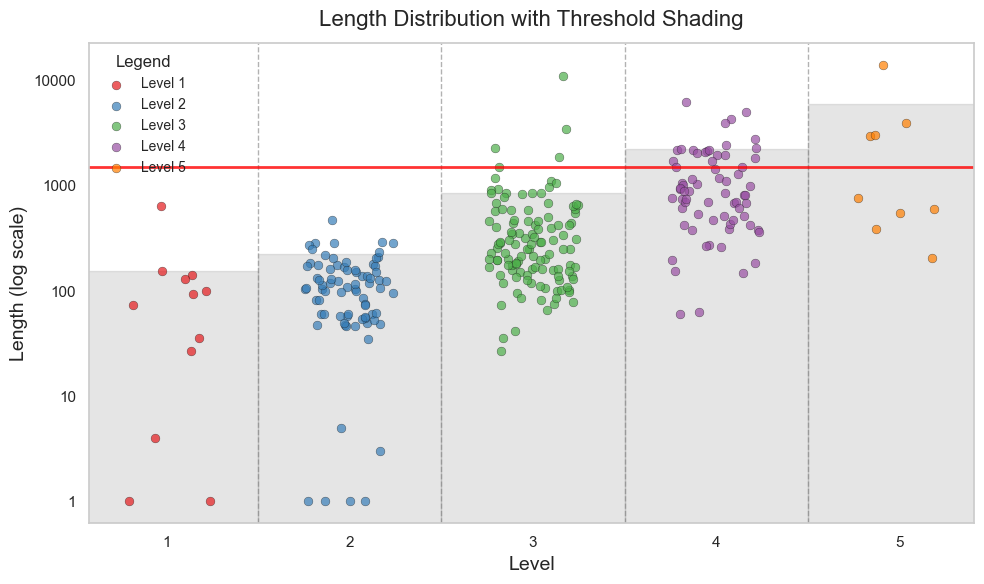

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Rectangle

alpha = 0.1
l_thresh = [np.quantile(r_ls[i],1-alpha) for i in [1,2,3,4,5]]


sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid': False})
cp = sns.color_palette("Set1", n_colors=5)

fig, ax = plt.subplots(figsize=(10, 6))

rng = np.random.default_rng(seed=42)
jitter_width = 0.25


for k, vals in r_ls.items():
    x_vals = k + rng.uniform(-jitter_width, jitter_width, len(vals))
    ax.scatter(x_vals, vals,
               s=40, alpha=0.7,
               color=cp[k-1], edgecolor='k', linewidth=0.3,
               label=f"Level {k}")


ax.set_yscale("log")
ax.yaxis.set_major_formatter(ScalarFormatter())


for x in range(1, 5):     
    ax.axvline(x + 0.5, color='grey', lw=1, alpha=0.6, linestyle='--')


ymin, ymax = ax.get_ylim() 
for k, thr in enumerate(l_thresh, start=1):
    rect = Rectangle((k - 0.5, ymin),       
                     width=1.0,             
                     height=thr - ymin,     
                     color='grey', alpha=0.2, zorder=0)
    ax.add_patch(rect)
ax.axhline(total_thersh,color='red', linestyle='-', linewidth=2, alpha=0.8)
ax.set_xticks(range(1, 6))
ax.set_xlabel("Level", fontsize=14)
ax.set_ylabel("Length (log scale)", fontsize=14)
ax.set_title("Length Distribution with Threshold Shading", fontsize=16, pad=12)
ax.legend(title="Legend", frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

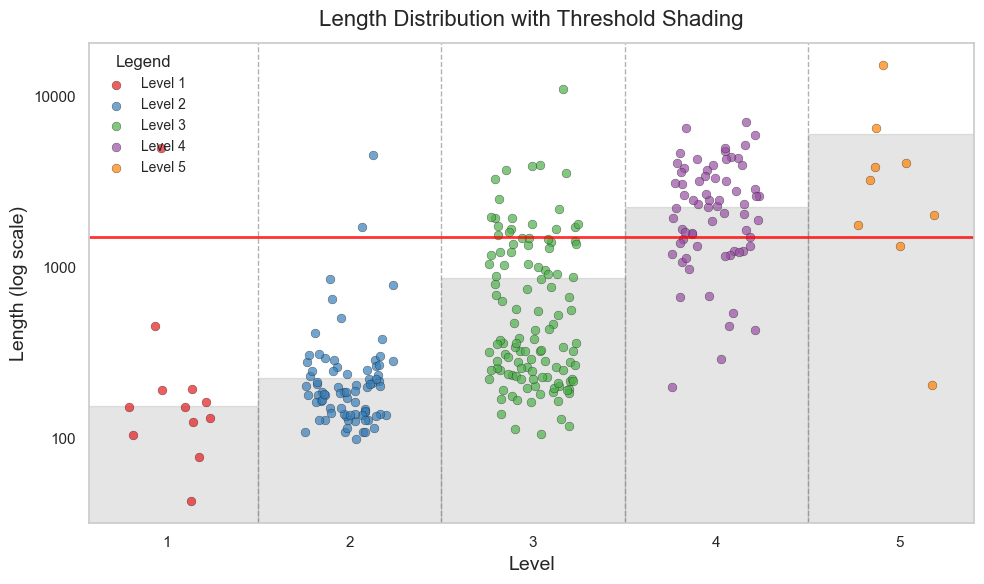

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Rectangle

alpha = 0.1
l_thresh = [np.quantile(r_ls[i],1-alpha) for i in [1,2,3,4,5]]


sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid': False})
cp = sns.color_palette("Set1", n_colors=5)

fig, ax = plt.subplots(figsize=(10, 6))

rng = np.random.default_rng(seed=42)
jitter_width = 0.25


for k, vals in original_ls.items():
    x_vals = k + rng.uniform(-jitter_width, jitter_width, len(vals))
    ax.scatter(x_vals, vals,
               s=40, alpha=0.7,
               color=cp[k-1], edgecolor='k', linewidth=0.3,
               label=f"Level {k}")


ax.set_yscale("log")
ax.yaxis.set_major_formatter(ScalarFormatter())


for x in range(1, 5):     
    ax.axvline(x + 0.5, color='grey', lw=1, alpha=0.6, linestyle='--')


ymin, ymax = ax.get_ylim() 
for k, thr in enumerate(l_thresh, start=1):
    rect = Rectangle((k - 0.5, ymin),       
                     width=1.0,             
                     height=thr - ymin,     
                     color='grey', alpha=0.2, zorder=0)
    ax.add_patch(rect)
ax.axhline(total_thersh,color='red', linestyle='-', linewidth=2, alpha=0.8)
ax.set_xticks(range(1, 6))
ax.set_xlabel("Level", fontsize=14)
ax.set_ylabel("Length (log scale)", fontsize=14)
ax.set_title("Length Distribution with Threshold Shading", fontsize=16, pad=12)
ax.legend(title="Legend", frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

In [27]:
for i in range(1, 6):
    arr_original = np.array(original_ls[i])
    arr_r = np.array(r_ls[i])

    diff = np.maximum(arr_original - arr_r, 0) 
    
    relative_reduction = np.mean(diff) / np.mean(arr_original)
    
    print(f"----Level {i}-----")
    print(f"Relative Reduction: {relative_reduction:.2%}") 

----Level 1-----
Relative Reduction: 79.15%
----Level 2-----
Relative Reduction: 58.60%
----Level 3-----
Relative Reduction: 43.60%
----Level 4-----
Relative Reduction: 50.89%
----Level 5-----
Relative Reduction: 30.13%


In [8]:
arr_pred_l = np.array(pred_ls)
arr_total_l = np.array(total_ls)

print(np.quantile(arr_total_l/arr_pred_l,1-alpha))
NC2_tao = np.quantile(arr_total_l/arr_pred_l,1-alpha)

2.1346739130434784


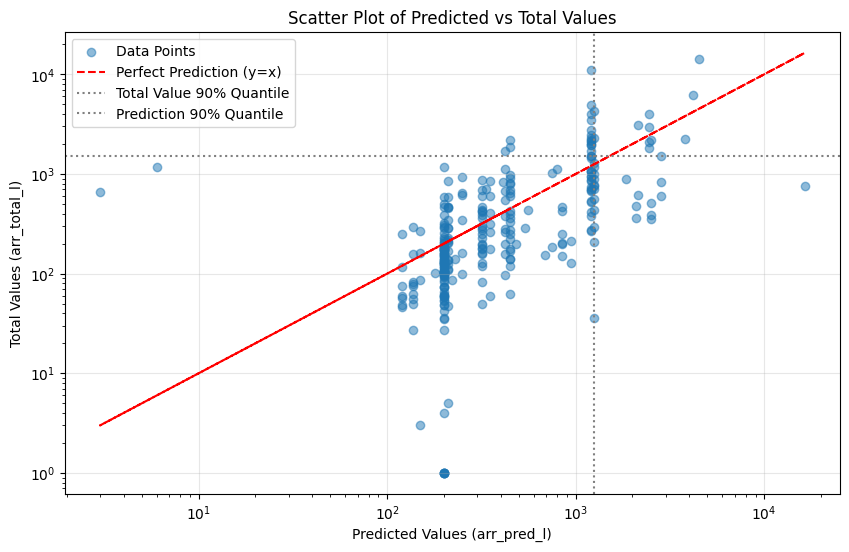

In [7]:
import matplotlib.pyplot as plt
import numpy as np
quantile_value = np.quantile(arr_total_l / arr_pred_l, 1 - alpha)

plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(arr_pred_l, arr_total_l, alpha=0.5, label="Data Points")

# Perfect prediction line
plt.plot(arr_pred_l, arr_pred_l, color='red', linestyle='--', label="Perfect Prediction (y=x)")

# Quantile lines
plt.axhline(y=np.quantile(arr_total_l, 1 - alpha), color='grey', linestyle=':', label=f"Total Value {1-alpha:.0%} Quantile")
plt.axvline(x=np.quantile(arr_pred_l, 1 - alpha), color='grey', linestyle=':', label=f"Prediction {1-alpha:.0%} Quantile")

# Set logarithmic scale for both axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel("Predicted Values (arr_pred_l)")
plt.ylabel("Total Values (arr_total_l)")
plt.title("Scatter Plot of Predicted vs Total Values")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


In [15]:
print(pred_ls)
pred_NC2 = np.array([pred_ls])*NC2_tao
arr_original_total = np.array([original_total])
diff2 = np.maximum(arr_original_total - pred_NC2, 0) 
relative_reduction2 = np.mean(diff2) / np.mean(arr_original_total)
print(relative_reduction2)

[200, 420, 150, 1200, 1200, 200, 1200, 1200, 320, 1850, 2500, 4500, 412, 200, 200, 200, 200, 333, 200, 200, 200, 1250, 1200, 250, 200, 200, 2150, 420, 1250, 2450, 450, 320, 1200, 450, 200, 1200, 200, 350, 450, 320, 1200, 1250, 1200, 200, 450, 450, 200, 450, 1200, 1200, 420, 200, 420, 320, 200, 350, 320, 200, 350, 200, 200, 320, 200, 2850, 200, 750, 138, 1250, 450, 1200, 200, 200, 250, 200, 200, 200, 2100, 200, 420, 200, 450, 200, 200, 210, 200, 210, 200, 210, 1200, 1200, 1250, 450, 200, 200, 450, 200, 1200, 420, 200, 542, 138, 2100, 480, 210, 120, 1200, 320, 200, 230, 210, 200, 320, 320, 200, 1200, 1200, 450, 200, 350, 450, 150, 200, 200, 200, 200, 200, 2500, 850, 200, 250, 250, 200, 850, 200, 420, 1250, 200, 320, 250, 320, 6, 450, 120, 200, 450, 1248, 200, 210, 138, 800, 210, 120, 210, 16384, 200, 200, 450, 850, 120, 1200, 210, 200, 350, 450, 562, 320, 138, 200, 1250, 2450, 200, 420, 1200, 320, 850, 320, 1250, 320, 120, 138, 200, 200, 200, 210, 1200, 200, 180, 1250, 1200, 200, 200, 21

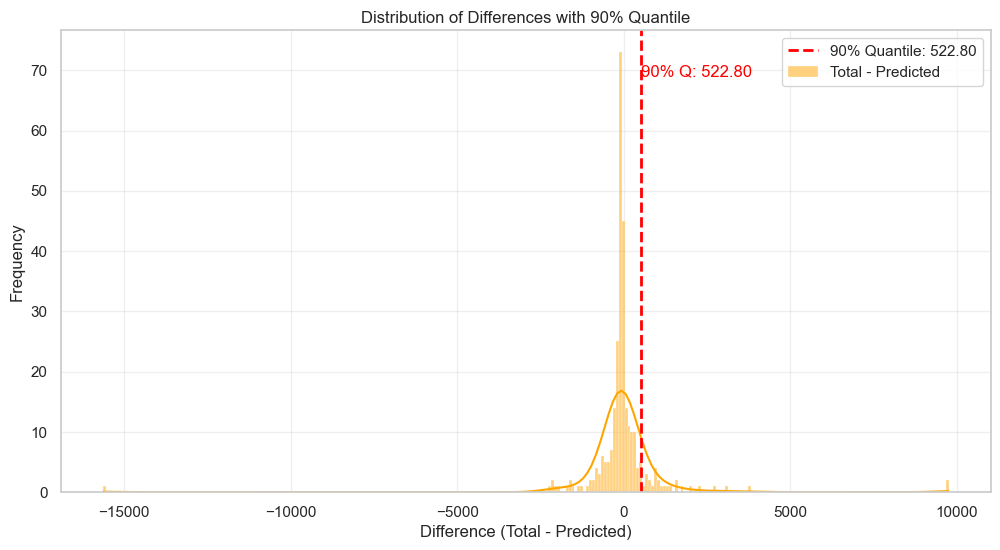

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


diff = arr_total_l - arr_pred_l
quantile_90 = np.quantile(diff, 0.9)  # 计算90%分位数

plt.figure(figsize=(12, 6))
sns.histplot(diff, kde=True, color='orange', label="Total - Predicted")
plt.axvline(quantile_90, color='red', linestyle='--', 
            linewidth=2, label=f'90% Quantile: {quantile_90:.2f}')
plt.text(quantile_90 + 0.1, plt.ylim()[1]*0.9, 
         f'90% Q: {quantile_90:.2f}', color='red', ha='left')

plt.xlabel("Difference (Total - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Differences with 90% Quantile")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

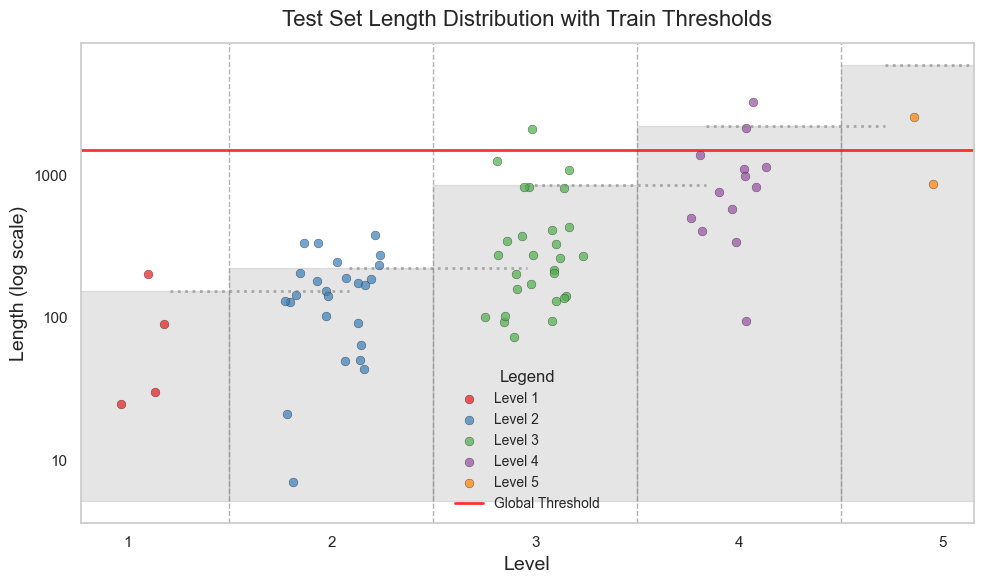

In [21]:
#test
test_r_ls = {1: [], 2: [], 3: [], 4: [], 5: []}
test_total_ls = []

for a_data in test:
    level = a_data["level"]
    r_l = a_data["r_l"]
    if level in test_r_ls:
        test_r_ls[level].append(r_l)
        test_total_ls.append(r_l)

plt.figure(figsize=(10, 6))

cp = sns.color_palette("Set1", n_colors=5)
rng = np.random.default_rng(seed=42)
jitter_width = 0.25


for k, vals in test_r_ls.items():
    x_vals = k + rng.uniform(-jitter_width, jitter_width, len(vals))
    plt.scatter(x_vals, vals,
                s=40, alpha=0.7,
                color=cp[k-1], edgecolor='k', linewidth=0.3,
                label=f"Level {k}")

plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

for x in range(1, 5):
    plt.axvline(x + 0.5, color='grey', lw=1, alpha=0.6, linestyle='--')


ymin, ymax = plt.ylim()
for k, thr in enumerate(l_thresh, start=1):
    rect = Rectangle((k - 0.5, ymin),
                    width=1.0,
                    height=thr - ymin,
                    color='grey', alpha=0.2, zorder=0)
    plt.gca().add_patch(rect)


plt.axhline(total_thersh, color='red', linestyle='-', linewidth=2, alpha=0.8, label='Global Threshold')
for k, thr in enumerate(l_thresh, start=1):
    plt.axhline(thr, xmin=(k-0.5)/5, xmax=(k+0.5)/5, 
                color='grey', linestyle=':', linewidth=2, alpha=0.6)

plt.xticks(range(1, 6))
plt.xlabel("Level", fontsize=14)
plt.ylabel("Length (log scale)", fontsize=14)
plt.title("Test Set Length Distribution with Train Thresholds", fontsize=16, pad=12)
plt.legend(title="Legend", frameon=False, fontsize=10)

plt.tight_layout()
plt.show()


test in another math dataset

In [37]:
from importlib import reload
import tools.data_collect
reload(tools.data_collect)
from tools.data_collect import Data_Processor
cwd = Path.cwd()
config_path = cwd / "configs" / "collect_config.json"
with open(config_path, 'r', encoding='utf-8') as f:
    collect_config = json.load(f)
collect_config['dataset_name']="Maxwell-Jia/AIME_2024"
ds = load_dataset(collect_config['dataset_name'], split="train")
processor = Data_Processor(
    # api_key=os.getenv("DEEPSEEK_API_KEY"),
    api_config= collect_config,
    max_workers=10,  
)

data_name = collect_config['dataset_name'].split("/")[-1]
output_path = cwd / "exp" / "test" /  f"{data_name}.jsonl"
output_path.parent.mkdir(parents=True, exist_ok=True)
processor.output_file = output_path # you can set the output_file by yourself, otherwise it is set by defalt
# dataset_path = setup_output_file(collect_config)
processor.process_dataset(ds, batch_size=1000)

Processing: 100%|██████████| 30/30 [28:26<00:00, 56.87s/it] 


In [ ]:
from importlib import reload
import tools.Prompt
import tools.pred
reload(tools.Prompt)
reload(tools.pred)
from tools.pred import predict_reasoning_length
test_file = r"exp\test\AIME_2024.jsonl"
predict_reasoning_length(input_path=test_file,
                        api_key="sk-28d3e9b60f9f43a0a958ae132b7fcc2f",
                        base_url="https://api.deepseek.com",
                        model_name="deepseek-chat")

In [3]:
import tools.data_test
from importlib import reload
cwd = Path.cwd()
reload(tools.data_test)
from tools.data_test import *
import tools.data_test
from functools import partial
total_thersh = 1504.2
l_thresh = [154.5, 224.89999999999998, 862.6, 2247.1000000000004, 6030.000000000002]

N_C_0 = partial(NC_0,tao=total_thersh)
N_C_0.__name__ = NC_0.__name__
N_C_1 = partial(NC_1,tao_list = l_thresh)
N_C_1.__name__ = "condition"
config_path = cwd / "configs" / "test_config.json"
test_file = r"exp\test\AIME_2024.jsonl"
with open(config_path, 'r', encoding='utf-8') as f:
    test_config = json.load(f)
evaluate_threshold(config=test_config,data_file=test_file,threshold_fn=N_C_0)

Processing entries: 100%|██████████| 30/30 [20:22<00:00, 40.74s/entry]

Done. Results written to exp\test\AIME_2024_evaluated.jsonl


In [2]:
import tools.data_test
from importlib import reload
from pathlib import Path
cwd = Path.cwd()
reload(tools.data_test)
from tools.data_test import *
import tools.data_test
from functools import partial
total_thersh = 1504.2
l_thresh = [154.5, 224.89999999999998, 862.6, 2247.1000000000004, 6030.000000000002]

N_C_0 = partial(NC_0,tao=total_thersh)
N_C_0.__name__ = NC_0.__name__
N_C_1 = partial(NC_1,tao_list = l_thresh)
N_C_1.__name__ = "condition"
config_path = cwd / "configs" / "test_config.json"
test_file = r"exp\test\AIME_2024.jsonl"
with open(config_path, 'r', encoding='utf-8') as f:
    test_config = json.load(f)
evaluate_threshold(config=test_config,data_file=test_file,threshold_fn=N_C_1)

Processing entries: 100%|██████████| 30/30 [22:32<00:00, 45.07s/entry]

Done. Results written to exp\test\AIME_2024_evaluated.jsonl
